In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time

USDC Top 10 Wallets - Weekly Time Series Analysis
Fetching top USDC holders...
Analyzing 10 wallets...
Created 26 weekly periods
Analyzing 0x37305b1c...
Analyzing 0x28c6c062...
Analyzing 0xad354cfb...
Analyzing 0xe1940f57...
Analyzing 0xf977814e...
Analyzing 0x420ef1f2...
Analyzing 0x47ac0fb4...
Analyzing 0x98c23e9d...
Analyzing 0xd54f23be...
Analyzing 0x01b86976...


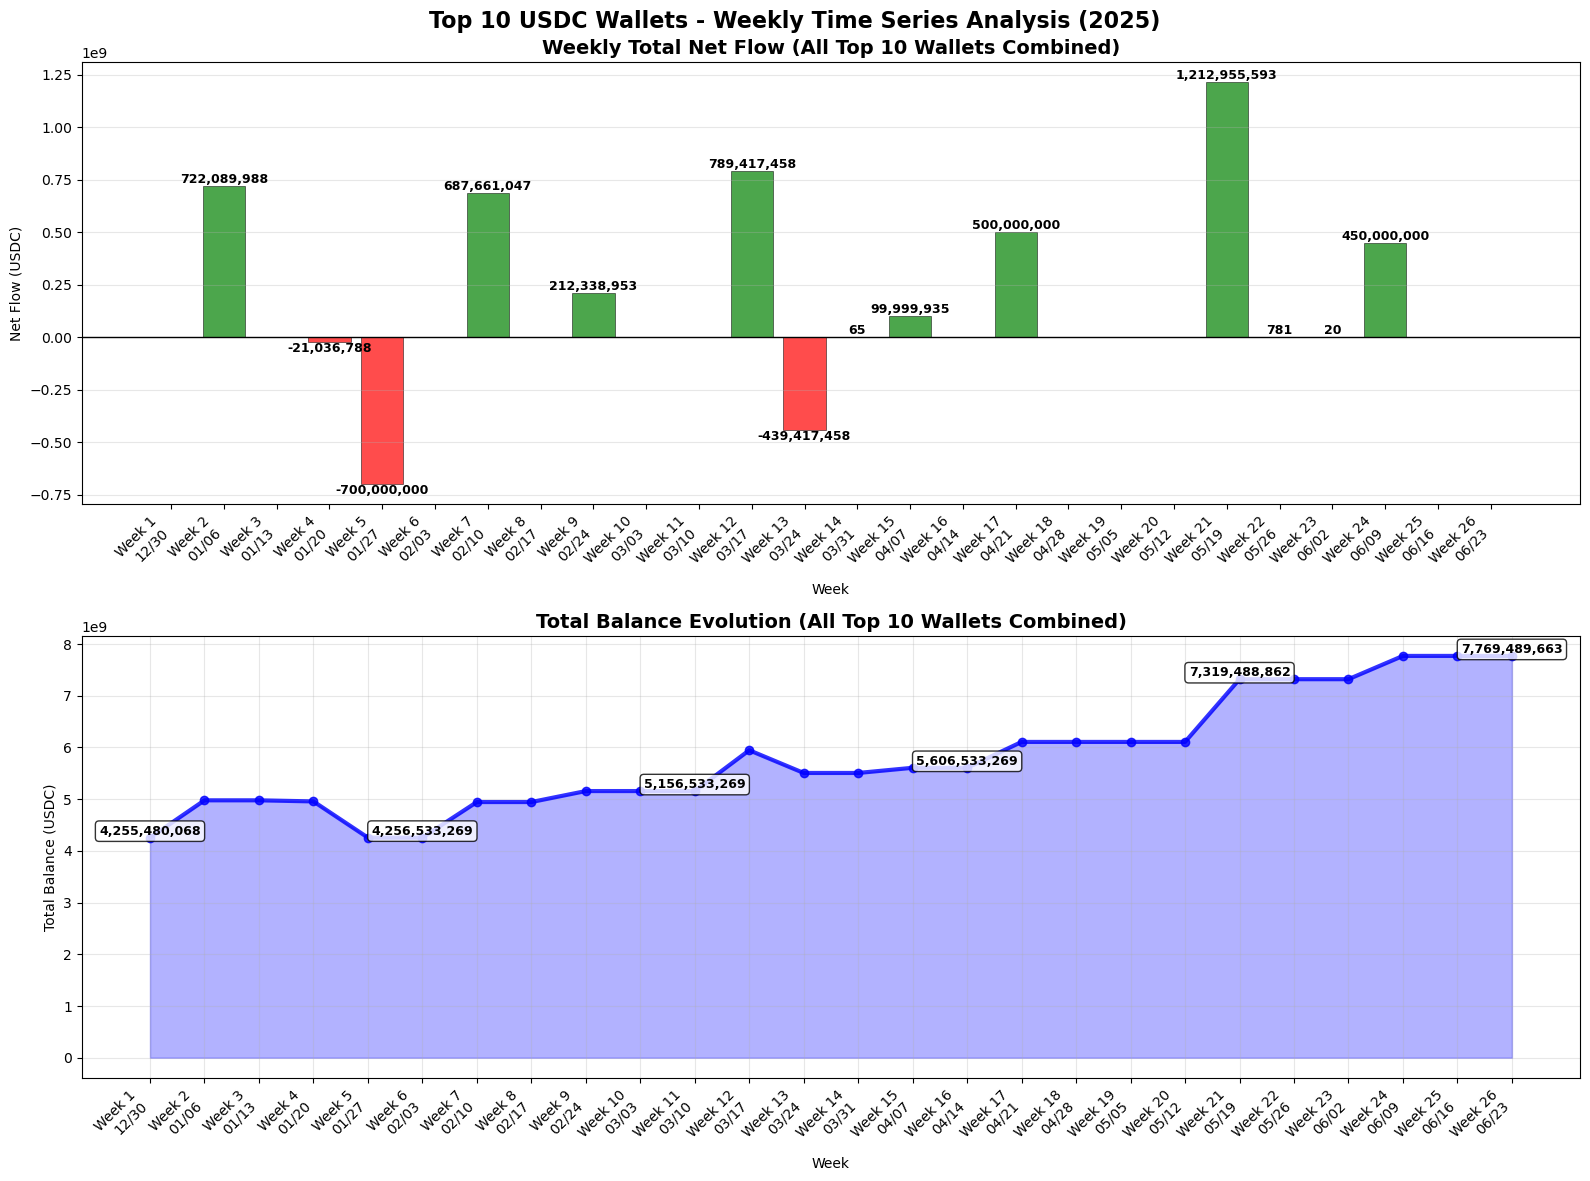


WEEKLY TIME SERIES SUMMARY
Analysis Period: 2025-01-01 to 2025-06-23
Number of weeks: 26

Week     Date       Net Flow        Total Balance   Flow Direction 
--------------------------------------------------------------------------------
1        12/30                  0 4,255,480,068 ⚖️ Neutral     
2        01/06        722,089,988 4,977,570,057 📈 Inflow       
3        01/13                  0 4,977,570,057 ⚖️ Neutral     
4        01/20        -21,036,788 4,956,533,269 📉 Outflow      
5        01/27       -700,000,000 4,256,533,269 📉 Outflow      
6        02/03                  0 4,256,533,269 ⚖️ Neutral     
7        02/10        687,661,047 4,944,194,315 📈 Inflow       
8        02/17                  0 4,944,194,315 ⚖️ Neutral     
9        02/24        212,338,953 5,156,533,269 📈 Inflow       
10       03/03                  0 5,156,533,269 ⚖️ Neutral     
11       03/10                  0 5,156,533,269 ⚖️ Neutral     
12       03/17        789,417,458 5,945,950,726 📈 Inflow

In [4]:
# Configuration
USDC_CONTRACT = "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48"  # USDC contract address
ETHPLORER_API_KEY = "ENTER YOUR ETHPLORER API KEY"  # Replace with your API key
ETHERSCAN_API_KEY = "ENTER YOUR ETHERSCAN API KEY"  # Replace with your API key
TOP_N_WALLETS = 10

# Period: Beginning of 2025 to now
START_DATE = datetime(2025, 1, 1)
END_DATE = datetime.now()

def get_top_usdc_holders():
    """Fetch top USDC holders from Ethplorer"""
    url = f"https://api.ethplorer.io/getTopTokenHolders/{USDC_CONTRACT}?apiKey={ETHPLORER_API_KEY}&limit={TOP_N_WALLETS}"
    resp = requests.get(url)
    data = resp.json()
    holders = []
    for h in data.get('holders', []):
        holders.append({
            'address': h['address'],
            'current_balance': float(h['balance']) / (10 ** 6),  # Convert to USDC (6 decimals)
            'share': h.get('share', 0)
        })
    return holders

def get_wallet_usdc_transfers(address):
    """Get all USDC transfers for a wallet"""
    url = (
        f"https://api.etherscan.io/api"
        f"?module=account"
        f"&action=tokentx"
        f"&contractaddress={USDC_CONTRACT}"
        f"&address={address}"
        f"&startblock=0"
        f"&endblock=99999999"
        f"&sort=asc"
        f"&apikey={ETHERSCAN_API_KEY}"
    )
    resp = requests.get(url)
    data = resp.json()
    if data.get('status') == "1":
        return pd.DataFrame(data['result'])
    else:
        return pd.DataFrame()

def create_weekly_periods():
    """Create list of weekly periods from start to end date"""
    weeks = []
    current = START_DATE
    while current <= END_DATE:
        # Get Monday of the week
        monday = current - timedelta(days=current.weekday())
        week_end = monday + timedelta(days=6)
        weeks.append({
            'week_start': monday,
            'week_end': min(week_end, END_DATE),
            'week_label': f"Week {len(weeks)+1}\n{monday.strftime('%m/%d')}"
        })
        current = monday + timedelta(days=7)
    return weeks

def analyze_wallet_weekly_flows(wallet_info, weekly_periods):
    """Get weekly flows and balances for a single wallet"""
    address = wallet_info['address']
    print(f"Analyzing {address[:10]}...")
    
    # Get transfers
    df_transfers = get_wallet_usdc_transfers(address)
    time.sleep(0.25)  # Rate limiting
    
    if df_transfers.empty:
        # Return zero flows for all weeks
        return pd.DataFrame([{
            'week_start': week['week_start'],
            'week_label': week['week_label'],
            'net_flow': 0,
            'balance': wallet_info['current_balance']  # Assume current balance throughout
        } for week in weekly_periods])
    
    # Process transfers
    df_transfers['timestamp'] = pd.to_datetime(pd.to_numeric(df_transfers['timeStamp']), unit='s')
    df_transfers['value'] = df_transfers['value'].astype(float) / (10 ** 6)  # USDC decimals
    df_transfers['flow'] = df_transfers.apply(
        lambda row: row['value'] if row['to'].lower() == address.lower() else -row['value'], 
        axis=1
    )
    
    # Calculate weekly flows and balances
    weekly_data = []
    cumulative_balance = 0
    
    # Get balance before 2025
    df_before_2025 = df_transfers[df_transfers['timestamp'] < START_DATE]
    if not df_before_2025.empty:
        cumulative_balance = df_before_2025['flow'].sum()
    
    for week in weekly_periods:
        # Get transfers for this week
        week_transfers = df_transfers[
            (df_transfers['timestamp'] >= week['week_start']) & 
            (df_transfers['timestamp'] <= week['week_end'])
        ]
        
        # Calculate net flow for this week
        net_flow = week_transfers['flow'].sum() if not week_transfers.empty else 0
        
        # Update cumulative balance
        cumulative_balance += net_flow
        
        weekly_data.append({
            'week_start': week['week_start'],
            'week_label': week['week_label'],
            'net_flow': net_flow,
            'balance': cumulative_balance
        })
    
    return pd.DataFrame(weekly_data)

def create_time_series_graphs(combined_weekly_data):
    """Create time series graphs for net flow and balance"""
    
    # Set up the plot style
    plt.style.use('default')
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    fig.suptitle('Top 10 USDC Wallets - Weekly Time Series Analysis (2025)', 
                 fontsize=16, fontweight='bold')
    
    # Prepare data
    weeks = combined_weekly_data['week_start']
    week_labels = combined_weekly_data['week_label']
    net_flows = combined_weekly_data['total_net_flow']
    balances = combined_weekly_data['total_balance']
    
    # Graph 1: Weekly Net Flow Time Series
    bars1 = ax1.bar(range(len(weeks)), net_flows, 
                    color=['green' if x >= 0 else 'red' for x in net_flows], 
                    alpha=0.7, edgecolor='black', linewidth=0.5)
    
    ax1.set_title('Weekly Total Net Flow (All Top 10 Wallets Combined)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Week')
    ax1.set_ylabel('Net Flow (USDC)')
    ax1.set_xticks(range(len(weeks)))
    ax1.set_xticklabels(week_labels, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars1, net_flows)):
        if abs(value) > 0:  # Only show labels for non-zero values
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:,.0f}', ha='center', 
                    va='bottom' if height >= 0 else 'top',
                    fontsize=9, fontweight='bold')
    
    # Graph 2: Total Balance Time Series
    line = ax2.plot(range(len(weeks)), balances, 
                    marker='o', linewidth=3, markersize=6, 
                    color='blue', alpha=0.8)
    
    ax2.fill_between(range(len(weeks)), balances, alpha=0.3, color='blue')
    
    ax2.set_title('Total Balance Evolution (All Top 10 Wallets Combined)', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Week')
    ax2.set_ylabel('Total Balance (USDC)')
    ax2.set_xticks(range(len(weeks)))
    ax2.set_xticklabels(week_labels, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on key points
    for i in range(0, len(weeks), max(1, len(weeks)//5)):  # Show every 5th point or so
        ax2.text(i, balances.iloc[i], f'{balances.iloc[i]:,.0f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("WEEKLY TIME SERIES SUMMARY")
    print("="*80)
    print(f"Analysis Period: {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}")
    print(f"Number of weeks: {len(combined_weekly_data)}")
    print()
    
    # Weekly breakdown
    print(f"{'Week':<8} {'Date':<10} {'Net Flow':<15} {'Total Balance':<15} {'Flow Direction':<15}")
    print("-" * 80)
    
    for _, row in combined_weekly_data.iterrows():
        flow_direction = "📈 Inflow" if row['total_net_flow'] > 0 else "📉 Outflow" if row['total_net_flow'] < 0 else "⚖️ Neutral"
        print(f"{row['week_label'].split()[1]:<8} {row['week_start'].strftime('%m/%d'):<10} "
              f"{row['total_net_flow']:>13,.0f} {row['total_balance']:>13,.0f} {flow_direction:<15}")
    
    # Overall statistics
    total_flow = combined_weekly_data['total_net_flow'].sum()
    max_inflow_week = combined_weekly_data.loc[combined_weekly_data['total_net_flow'].idxmax()]
    max_outflow_week = combined_weekly_data.loc[combined_weekly_data['total_net_flow'].idxmin()]
    final_balance = combined_weekly_data['total_balance'].iloc[-1]
    initial_balance = combined_weekly_data['total_balance'].iloc[0]
    
    print("\n" + "="*80)
    print("KEY INSIGHTS")
    print("="*80)
    print(f"• Total net flow across all weeks: {total_flow:,.0f} USDC")
    print(f"• Starting total balance: {initial_balance:,.0f} USDC")
    print(f"• Ending total balance: {final_balance:,.0f} USDC")
    print(f"• Overall balance change: {final_balance - initial_balance:,.0f} USDC")
    print()
    print(f"• Biggest inflow week: {max_inflow_week['week_label']} ({max_inflow_week['total_net_flow']:,.0f} USDC)")
    print(f"• Biggest outflow week: {max_outflow_week['week_label']} ({max_outflow_week['total_net_flow']:,.0f} USDC)")
    print(f"• Weeks with net inflow: {len(combined_weekly_data[combined_weekly_data['total_net_flow'] > 0])}")
    print(f"• Weeks with net outflow: {len(combined_weekly_data[combined_weekly_data['total_net_flow'] < 0])}")

def main():
    """Main function"""
    print("USDC Top 10 Wallets - Weekly Time Series Analysis")
    print("="*60)
    
    # Get top wallets
    print("Fetching top USDC holders...")
    top_wallets = get_top_usdc_holders()
    
    if not top_wallets:
        print("Failed to fetch wallets. Check API configuration.")
        return
    
    print(f"Analyzing {len(top_wallets)} wallets...")
    
    # Create weekly periods
    weekly_periods = create_weekly_periods()
    print(f"Created {len(weekly_periods)} weekly periods")
    
    # Analyze each wallet
    all_wallet_data = []
    for wallet in top_wallets:
        wallet_weekly_data = analyze_wallet_weekly_flows(wallet, weekly_periods)
        wallet_weekly_data['address'] = wallet['address']
        all_wallet_data.append(wallet_weekly_data)
    
    # Combine all wallet data
    combined_df = pd.concat(all_wallet_data, ignore_index=True)
    
    # Aggregate by week (sum across all wallets)
    weekly_aggregated = combined_df.groupby(['week_start', 'week_label']).agg({
        'net_flow': 'sum',
        'balance': 'sum'
    }).reset_index()
    
    weekly_aggregated.columns = ['week_start', 'week_label', 'total_net_flow', 'total_balance']
    weekly_aggregated = weekly_aggregated.sort_values('week_start')
    
    # Create time series graphs
    create_time_series_graphs(weekly_aggregated)
    
    # Save results
    output_file = f"usdc_weekly_timeseries_{START_DATE.strftime('%Y%m%d')}_{END_DATE.strftime('%Y%m%d')}.csv"
    weekly_aggregated.to_csv(output_file, index=False)
    print(f"\nWeekly data saved to: {output_file}")
    
    return weekly_aggregated

if __name__ == "__main__":
    results = main()